In [1]:
import tensorflow as tf 
import numpy as np
import cv2
from matplotlib import pyplot as plt

import glob
import os

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split
import seaborn as sns
import imgaug.augmenters as iaa
import imgaug.imgaug
import random
import time

In [2]:
class ImageDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_list, labels, batch_size=16, input_dim=(512, 512), n_classes=2, shuffle=True, augment=False):
        self.input_dim = input_dim
        self.image_list = image_list
        self.labels = labels
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.image_list) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        
        # Find matching image list according to batch size
        list_id_temps = [self.image_list[k] for k in indexes]
        
        # Generate data
        x, y = self.data_generator(list_id_temps)
        if self.augment:
            x = self.augmentor(x)
        
        x = np.array([img / 255. for img in x])
        return x, y
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def data_generator(self, list_id_temp):
        # Initialize
        x = np.empty((self.batch_size, self.input_dim[0], self.input_dim[1], 3))
        y = np.empty((self.batch_size), dtype=np.int)
        
        # Generate data
        for index, ids in enumerate(list_id_temp):
            img = cv2.imread(ids)
            img = cv2.resize(img, self.input_dim)
            
            label = self.labels[os.path.basename(os.path.dirname(ids))]
            
            x[index, ] = img
            y[index, ] = label
            
        return x, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def augmentor(self, images):
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                rotate=(-25, 25)
            )
        ], random_order=True)
        
        return seq(images=images)

# Build simple CNN

In [3]:
# Hyperparams
input_size = (224, 224, 3)
learning_rate = 1e-4
batch_size = 32
epoch = 20

In [4]:
"""Tensorflow-Keras Implementation of Mish"""

## Import Necessary Modules
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [5]:
model = tf.keras.models.Sequential()

model.add(tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_size, pooling='max'))
model.layers[0].trainable = False
# model.add(tf.keras.layers.InputLayer(input_shape=input_size))
# model.add(tf.keras.layers.Conv2D(128, (2, 2)))
# model.add(tf.keras.layers.Activation('Mish'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Conv2D(64, (2, 2)))
# model.add(tf.keras.layers.Activation('Mish'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Dropout(0.2))

# model.add(tf.keras.layers.Conv2D(32, (3, 3)))
# model.add(tf.keras.layers.Activation('Mish'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0

# Load data & train

In [6]:
labels = {
    'hot_dog': 1,
    'not_hot_dog': 0
}

data = glob.glob('data/**/**/*.jpg', recursive=True)
# test_data = glob.glob('data/test/**/*.jpg', recursive=True)

In [7]:
train_data, test_data = train_test_split(data, test_size=0.4, random_state=42, stratify=data)

In [8]:
train_gen = ImageDataGen(train_data, labels, batch_size=batch_size, input_dim=input_size[:2], augment=False)
test_gen = ImageDataGen(test_data, labels, batch_size=batch_size, input_dim=input_size[:2], shuffle=False)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', patience=10, verbose=1, min_delta=0.001
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', mode='max', patience=5, verbose=1, min_delta=0.001
)
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'weights/hotdog_classifier.h5', monitor='val_accuracy', mode='max', save_best_only=True
)

In [10]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epoch,
    validation_data=test_gen,
    validation_steps=len(test_data) // batch_size,
    callbacks=[reduce_lr, early_stopping, model_ckpt]
)

Epoch 1/20
56/56 [==============================] - 12s 206ms/step - loss: 1.5477 - accuracy: 0.6802 - val_loss: 0.4890 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 2/20
56/56 [==============================] - 10s 176ms/step - loss: 0.8301 - accuracy: 0.7896 - val_loss: 0.3596 - val_accuracy: 0.8699 - lr: 1.0000e-04
Epoch 3/20
36/56 [==================>...........] - ETA: 1s - loss: 0.5503 - accuracy: 0.8351

KeyboardInterrupt: 

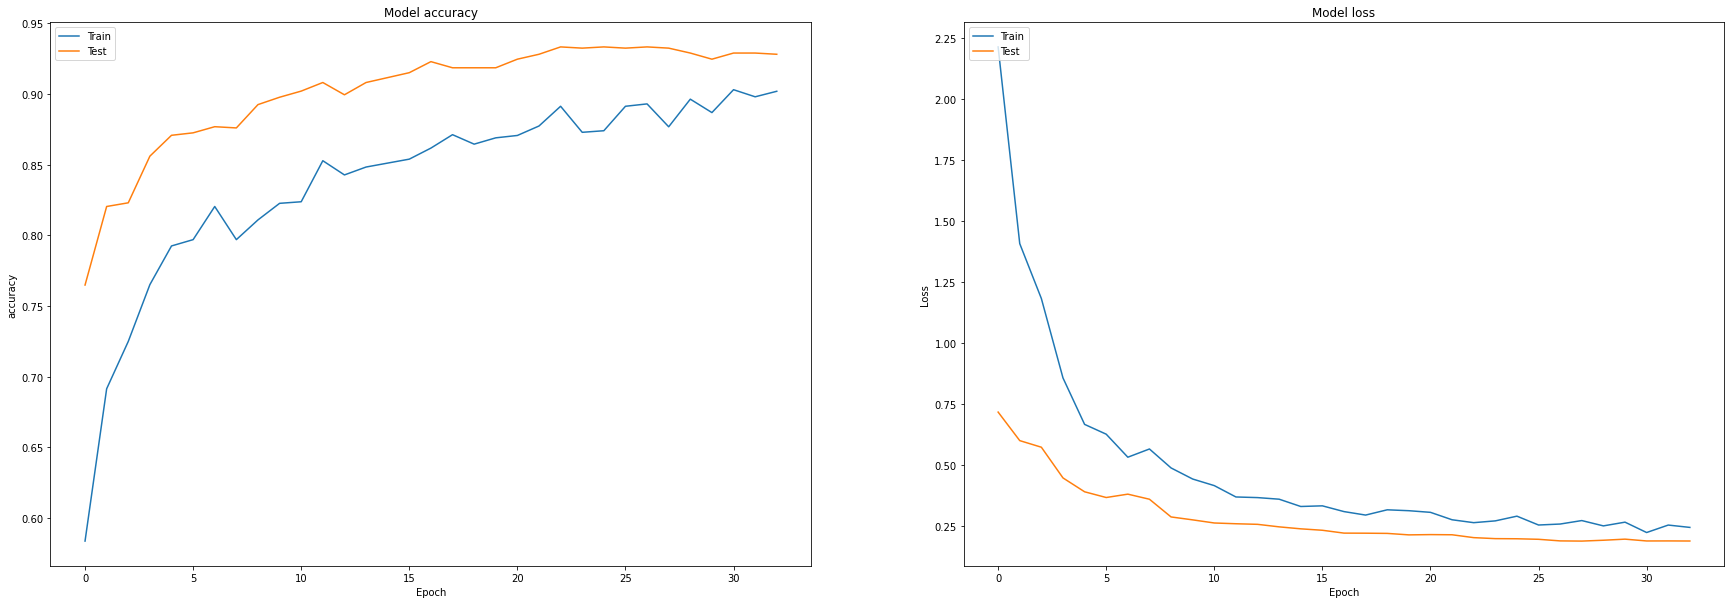

In [11]:
# plot history
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Evaluation

In [12]:
model = tf.keras.models.load_model('weights/hotdog_classifier.h5', compile=False, custom_objects={'mish': tf.keras.layers.Activation('Mish')})

In [13]:
y_pred = []
y_true = []
for dat in test_data:
    img = cv2.imread(dat)
    img = cv2.resize(img, input_size[:2])
    img = img / 255.
    y_pred.append(img)
    
    y_true.append(labels[os.path.basename(os.path.dirname(dat))])

y_pred = model.predict(np.array(y_pred))

true_y_pred = []
for pred in y_pred:
    true_y_pred.append(np.argmax(pred))

In [14]:
report = classification_report(y_true, true_y_pred)
conf_mat = confusion_matrix(y_true, true_y_pred)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       594
           1       0.95      0.91      0.93       604

    accuracy                           0.93      1198
   macro avg       0.93      0.93      0.93      1198
weighted avg       0.93      0.93      0.93      1198

MCC: 0.87


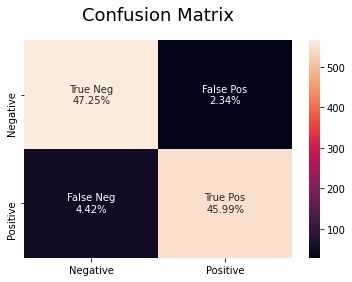

In [15]:
categories = ['Negative', 'Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']

group_percentage = [
    '{0:.2%}'.format(value) for value in conf_mat.ravel() / conf_mat.sum()
]

cm_labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentage)]

cm_labels = np.array(cm_labels).reshape(2, 2)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
sns.heatmap(
    conf_mat, annot=cm_labels, fmt='',
    xticklabels=categories, yticklabels=categories
)

print(report)
print('MCC: {}'.format(round(matthews_corrcoef(y_true, true_y_pred), 2)))

# Visually Inspect

In [16]:
test_labels = {
    1: 'hot_dog',
    0: 'not_hot_dog'
}

Infercence Time: 0.72


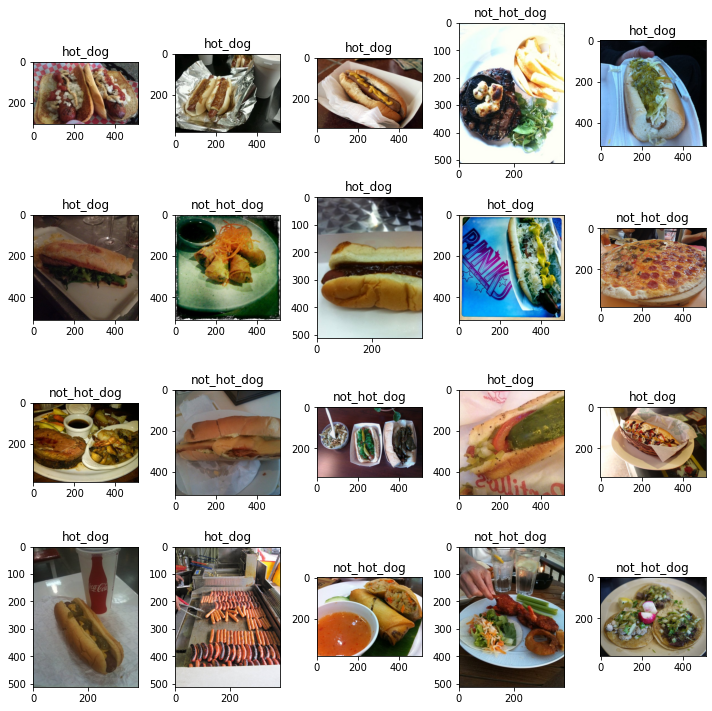

In [17]:
random.shuffle(test_data)

row, column = 4, 5
count = 0
plt.figure(figsize=(10, 10))

start_time = time.time()
for image_path in test_data[:20]:
    img = cv2.imread(image_path)
    img_copy = cv2.resize(img, input_size[:2])
    img_copy = img_copy / 255.
    
    pred = model.predict(np.expand_dims(img_copy, axis=0))
    
    count += 1
    plt.subplot(row, column, count)
    plt.title(test_labels[np.argmax(pred)])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
print('Infercence Time: {}'.format(round(time.time() - start_time, 2)))
plt.tight_layout()

# Convert model to saved model

In [18]:
tf.saved_model.save(model, 'weights/saved_model/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: weights/saved_model/assets


In [19]:
loaded = tf.saved_model.load('weights/saved_model/')
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']
